In [1]:
%load_ext autoreload
%autoreload 2

import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import numpy as np
import pandas as pd
import scipy.stats

In [2]:
import batchglm.api as glm
import diffxpy.api as de

print("batchglm version "+glm.__version__)
print("diffpy version "+de.__version__)

batchglm version v0.6.8
diffpy version v0.6.13


# Introduction

Continuous covariates appear in different contexts, most common in gene expression are total count covariates, time, pseudotime, space and stimulus concentration. They all have in common that the gene expression model cannot be broken down into discrete groups wihtouth binning the covariate. This is why we refer to the covariates as "continuous" which stands in constrast to "discrete" labels such as condition indicators. There are different ways to account for such continuous covariates in differential expression analysis: We dedicated this notebook to these scenarios and their relation to each other.

# Test for a non-constant trend

## Generate data:

Here, we simulate a time series. `batchglm` does not have a dedicated time series simulator yet so we simply simulate 7 independent conditions, which will lead to non-constant trends across time if these 7 conditions are concatenated as time points.

In [74]:
from batchglm.api.models.glm_nb import Simulator

sim = Simulator(num_observations=700, num_features=100)
sim.generate_sample_description(num_batches=0, num_conditions=7)
sim.generate_params(
    rand_fn_loc=lambda shape: np.random.uniform(-0.1, 0.1, shape),
    rand_fn_scale=lambda shape: np.random.uniform(0.1, 2, shape)
)
sim.generate_data()

data = anndata.AnnData(
    X=sim.x,
    var=pd.DataFrame(index=["gene" + str(i) for i in range(sim.x.shape[1])]),
    obs=sim.sample_description
)

Transforming to str index.


In [75]:
data.obs

,condition,batch
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,0,0
8,1,0
9,2,0


In [173]:
import scanpy as sc

adata=sc.read_loom('/Users/derekbogdanoff/projects/XYZeq/L20C1_raw.loom')

In [174]:
adata_macrophage = adata[adata.obs['CellType'] == 'Macrophage']

In [175]:
###remove NaN rows

adata_macrophage = adata_macrophage[~adata_macrophage.obs['prox_2'].isnull()]

In [191]:
#filter out human genes
adata_macrophage = adata_macrophage[:,adata_macrophage.var_names.str.startswith('mm10_')]

### Numeric covariates

Firstly, you have to indicate that you are supplying a continuous effect if you want to do so. We will otherwise turn it into a catgeorical effect and this will not produce the desired results. We do this so that we can make sure that there are no errors arising from numeric and catgeorical columns in pandas DataFrames. Here, we add the size factor into the anndata object to make it accessible to the model:

In [95]:
# time_list = np.array([1, 2, 3, 4, 5, 8, 10])



# data.obs["time"] = [time_list[int(x)] for x in data.obs["condition"].values]



# data.obs["individual"] = [str(np.random.randint(0, 3)) + "_" + str(x) for x in data.obs["time"].values]

In [118]:
#adata_macrophage = adata_macrophage.obs.drop(['prox_20','prox_21','prox_22','prox_23'],axis=1)

In [192]:
adata_macrophage.obs['time'] = adata_macrophage.obs['prox_2']

Trying to set attribute `.obs` of view, copying.


## Run test with spline basis

It may be desirable to not fit a linear trend to a continuous covariate but to allow smooth trends in this covariate, such as smooth trends of total counts, time, space or concentration. This can be solved by using a spline basis space representation of the continuous covariate. Diffxpy does this automatically in a separate wrapper `continuous_1d()`:

In [121]:
# det = de.test.continuous_1d(
#     data=data.X,
#     sample_description=data.obs,
#     gene_names=data.var_names,
#     formula_loc="~ 1 + time",
#     formula_scale="~ 1",
#     factor_loc_totest="time",
#     continuous="time",
#     size_factors=np.random.uniform(0.2, 2, data.n_obs),
#     df=4,
#     quick_scale=False
# )

INFO:tensorflow:Step: 0 loss: 741.771603 models converged 0
INFO:tensorflow:Step: 1 loss: 734.099494, converged 0 in 0.483 sec., updated 100, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 2 loss: 732.495175, converged 0 in 0.063 sec., updated 100, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 3 loss: 732.123370, converged 0 in 0.071 sec., updated 100, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 4 loss: 732.044874, converged 0 in 0.068 sec., updated 100, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 5 loss: 732.029779, converged 0 in 0.066 sec., updated 100, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 6 loss: 732.027001, converged 0 in 0.066 sec., updated 100, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 7 loss: 732.026499, converged 0 in 0.063 sec., updated 100, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 8 loss: 732.026409, converged 0 in 0.063 sec., updated 100, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 9 loss: 732.026392, converged 0 in 0.064 sec., updated 100, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 10 loss: 

In [122]:
data.obs

,condition,batch,time,individual,time0,time1,time2,time3
0,0,0,1,1_1,0.000000,0.000000,0.000000,0.000000
1,1,0,2,0_2,0.609053,0.090535,0.004115,0.000000
2,2,0,3,0_3,0.650206,0.279835,0.032922,0.000000
3,3,0,4,1_4,0.444444,0.444444,0.111111,0.000000
4,4,0,5,1_5,0.257202,0.488683,0.249486,0.004630
5,5,0,8,2_8,0.016461,0.164609,0.522634,0.296296
6,6,0,10,1_10,0.000000,0.000000,0.000000,1.000000
7,0,0,1,2_1,0.000000,0.000000,0.000000,0.000000
8,1,0,2,1_2,0.609053,0.090535,0.004115,0.000000
9,2,0,3,0_3,0.650206,0.279835,0.032922,0.000000


In [193]:
det = de.test.continuous_1d(
   
    data=adata_macrophage.X,
    
    sample_description=adata_macrophage.obs,
    
    gene_names=adata_macrophage.var_names,
    
    formula_loc="~ 1 + time",
    formula_scale="~ 1",
    factor_loc_totest="time",
    continuous="time",
    
    size_factors=np.random.uniform(0.2, 2, adata_macrophage.n_obs),
    
    df=4,
    
    quick_scale=False
    
)

INFO:tensorflow:Step: 0 loss: 7318.045258 models converged 0
INFO:tensorflow:Step: 1 loss: 7267.647927, converged 9062 in 4.464 sec., updated 23832, {f: 0, g: 9062, x: 0}
INFO:tensorflow:Step: 2 loss: 7255.819042, converged 9062 in 4.051 sec., updated 12345, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 3 loss: 7247.795205, converged 9062 in 3.733 sec., updated 12517, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 4 loss: 7241.100974, converged 9062 in 3.481 sec., updated 12787, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 5 loss: 7235.760627, converged 9062 in 3.465 sec., updated 12815, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 6 loss: 7229.176803, converged 9062 in 3.374 sec., updated 12603, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 7 loss: 7210.843375, converged 9062 in 3.58 sec., updated 11796, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 8 loss: 7208.360644, converged 9063 in 3.651 sec., updated 10572, {f: 1, g: 0, x: 0}
INFO:tensorflow:Step: 9 loss: 7206.803930, converged 9063 in 3.622 sec., updated 

The differential expression analysis results can be accessed as for other tests:

In [194]:
det.summary().iloc[:5, :]

,gene,pval,qval,log2fc,mean,zero_mean,grad,ll
0,mm10___Xkr4,0.953169,1.0,19.167403,0.006463,False,3.920771e-03,-2.067215e+01
1,mm10___Gm1992,1.000000,1.0,429.600000,0.000000,True,9.251313e-128,-3.949287e-125
2,mm10___Gm37381,1.000000,1.0,429.600000,0.000000,True,9.251313e-128,-3.949287e-125
3,mm10___Rp1,0.896741,1.0,420.921776,0.003231,False,1.912795e-03,-1.053798e+01
4,mm10___Rp1-1,0.896741,1.0,420.921776,0.003231,False,1.912795e-03,-1.053798e+01


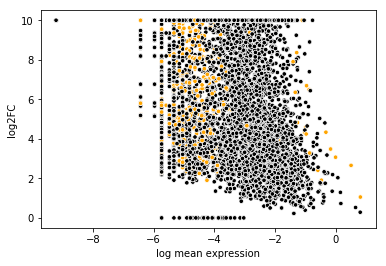

In [195]:
det.plot_ma()

### The spline basis

This test was based on the transformation of the continuous covariate (an observations x 1 matrix) into a spline basis space of size observations x df. In this basis space, a non-linear function can be represented as the weighted sum of basis functions ("waves"), this weighted sum is what the linear model estimates. To guide the intuition of the reader, we plot these basis functions here: diffpxy saves the basis functions into the sample description with the name of the continuous covariate followed by the numeric index of the basis function: Here, this is `['time0', 'time1', 'time2', 'time3']`.

In [196]:
adata_macrophage.obs.columns

Index(['CellType', 'Tissue_2', 'barcode', 'cell_call', 'human_counts',
       'leiden', 'log_counts', 'mouse_counts', 'n_counts', 'n_genes',
       'percent_contam', 'percent_mito_human', 'percent_mito_mouse', 'prox_1',
       'prox_2', 'ratio', 'time', 'time0', 'time1', 'time2', 'time3'],
      dtype='object')

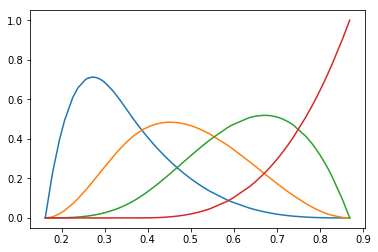

In [197]:
for x in ['time0', 'time1', 'time2', 'time3']:
    sns.lineplot(x=adata_macrophage.obs["time"].values, y=adata_macrophage.obs[x].values)

Note that there are 4 basis functions because there we allowed 4 degrees of freedom for the spline model, which corresponds to one weight for each basis function. The intercept is not included in these 4 parameters that describe relative behaviour in time: If you chose `df=4` and test the continuous effect, this means that your differential expression test will test 4 degrees of freedom. Here, we only sampled at discrete time points, the waves would appear smoother in this plot if the sampling along the continuous covariate was more dense.

Also note that you do not have to look at these splines when you perform model fitting or differential expression analysis, you can treat spline basis transforms as an established form of handling such data. We only produce this visualisation here to guide the intuition of readers who are exposed to this for the first time.

# Plot trajectories

## Heatmap

A side by side visualisation of the fitted models across many genes can be done by plotting a heatmap in which each gene is a row and the columns are ticks along the continuous covariate. Depending on the range of fitted expression values across genes, this heatmap may not be visually informative because a single color scale is not suited to show differences within a trajectory and between the trajectories. In these cases, it can make sense to look at z-score transformed fits so that the information is reduced to relative changes along the gene-wise trajectories.

In [233]:
genes=pd.read_csv('/Users/derekbogdanoff/projects/XYZeq/mac_tumor_inner_DE_2.csv')['names'].tolist()[:100]

In [234]:
len(genes)

100

In [235]:
for item in genes:
    if 'GRCh38_' in item:
        genes.pop(genes.index(item))

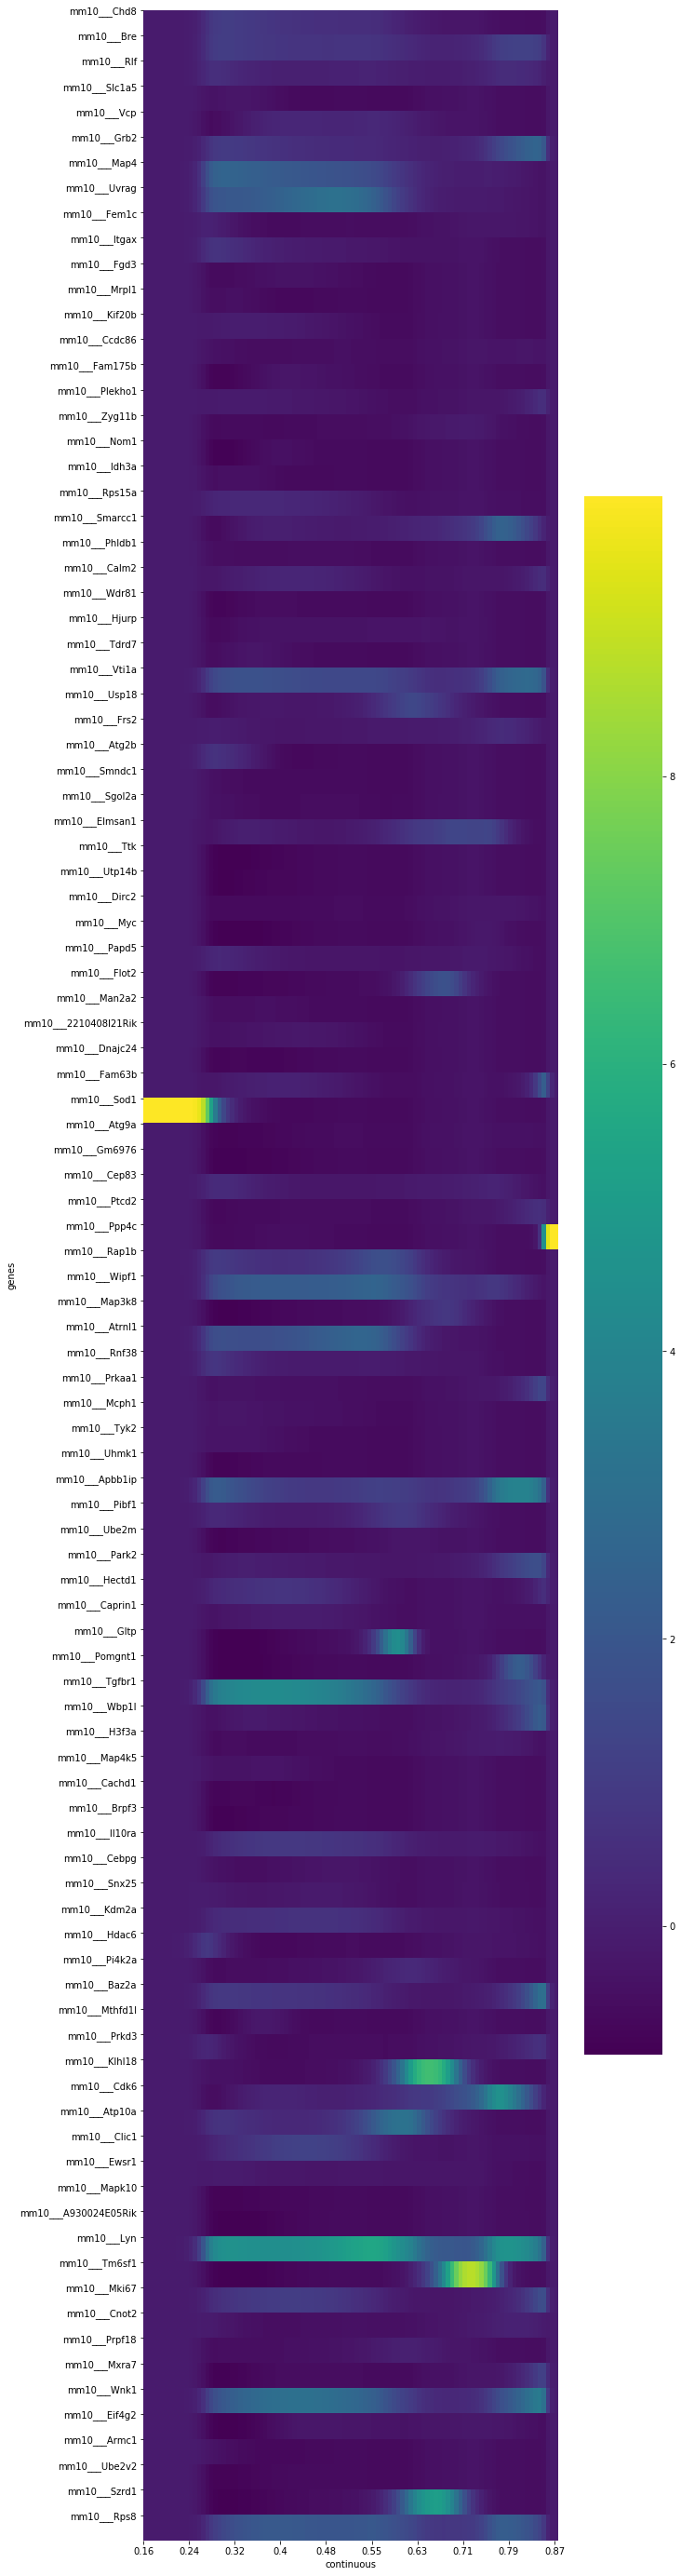

In [236]:
det.plot_heatmap(genes=genes,
                 cmap='viridis'
                )

In [221]:
det.summary()

,gene,pval,qval,log2fc,mean,zero_mean,grad,ll
0,mm10___Xkr4,0.953169,1.000000,19.167403,0.006463,False,3.920771e-03,-2.067215e+01
1,mm10___Gm1992,1.000000,1.000000,429.600000,0.000000,True,9.251313e-128,-3.949287e-125
2,mm10___Gm37381,1.000000,1.000000,429.600000,0.000000,True,9.251313e-128,-3.949287e-125
3,mm10___Rp1,0.896741,1.000000,420.921776,0.003231,False,1.912795e-03,-1.053798e+01
4,mm10___Rp1-1,0.896741,1.000000,420.921776,0.003231,False,1.912795e-03,-1.053798e+01
5,mm10___Sox17,1.000000,1.000000,429.600000,0.000000,True,9.251313e-128,-3.949287e-125
6,mm10___Gm37323,1.000000,1.000000,429.600000,0.000000,True,9.251313e-128,-3.949287e-125
7,mm10___Mrpl15,0.962220,1.000000,20.706855,0.017773,False,3.301554e-03,-3.901470e+01
8,mm10___Lypla1,0.979287,1.000000,48.816353,0.019909,False,6.702867e-03,-4.485756e+01
9,mm10___Gm37988,0.595780,1.000000,4.256505,0.031542,False,4.849735e-03,-5.694668e+01


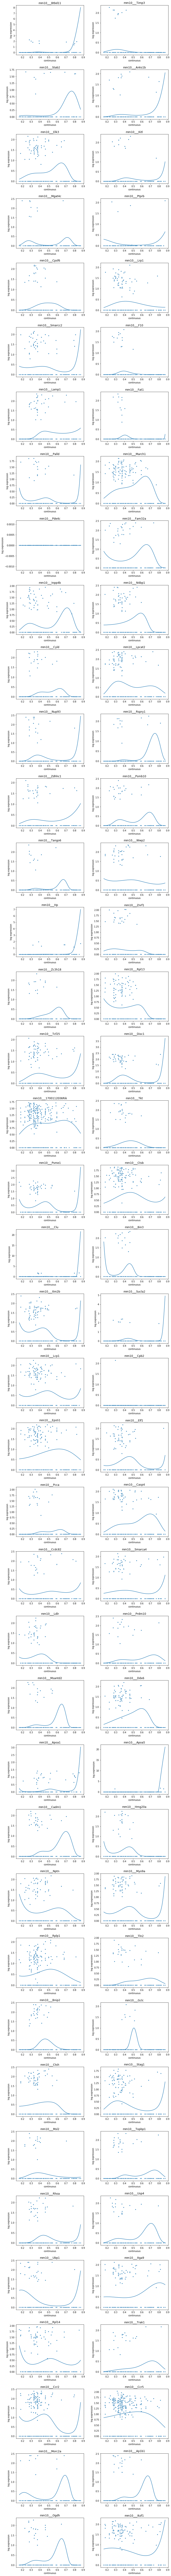

In [171]:
det.plot_genes(genes=adata_macrophage.var_names[480:560])

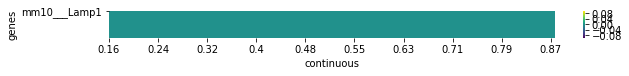

In [172]:
det.plot_heatmap(
    cmap='viridis',
    genes=['mm10___Lamp1'],# adata_macrophage.var_names[480:560],
    transform="zscore",

)

In [237]:
pwd

'/Users/derekbogdanoff/projects/bin/diffxpy_tutorials/diffxpy_tutorials/test'

In [159]:
adata_macrophage.var_names

Index(['GRCh38_PRDM16', 'GRCh38_VPS13D', 'GRCh38_KDM1A', 'GRCh38_RPL11',
       'GRCh38_CTPS1', 'GRCh38_KIF2C', 'GRCh38_RPS8', 'GRCh38_MAST2',
       'GRCh38_BTF3L4', 'GRCh38_FAM73A',
       ...
       'mm10___Ms4a6c', 'mm10___Abhd17b', 'mm10___March5', 'mm10___Rbp4',
       'mm10___Tbc1d12', 'mm10___Cyp2c50', 'mm10___Hoga1', 'mm10___Sema4g',
       'mm10___Sufu', 'mm10___Acsl5'],
      dtype='object', length=744)

## Single plot per gene

It is not necessary to use a z-score transform to plot the fit of a single gene. Here, we can plot the continuous model fit as a line and the observations as points, with expression on the y-axis and the continous covariate on the x-axis. It often makes sense to log transform expression in this plot so that (the mean dependent!) variance of the data (count data) does not dominate the plot in regions.

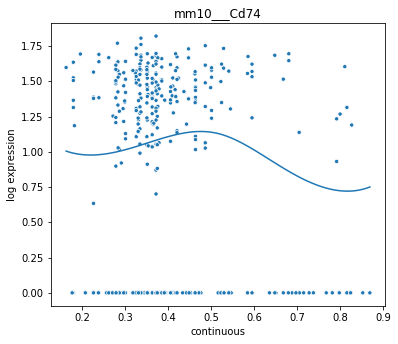

In [163]:
det.plot_genes(
    genes=['mm10___Cd74'] ,#      adata_macrophage.var_names[:3],
    log=True
    
)

# Gene-wise trajectory characteristics

##  Extrema of the fit

### Maximum and minimum

We can use the continous model fit (the line in the gene-wise plots above) to extract the minimum or maximum expression fit across the observed interval:

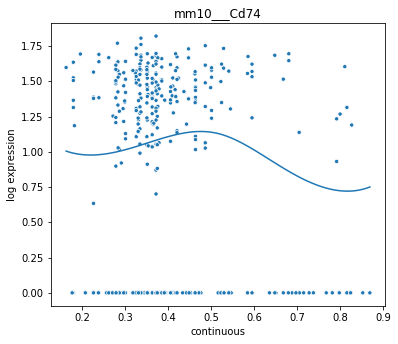

In [154]:
det.plot_genes(
    genes=['mm10___Cd74'],#data.var_names[0],
    log=True
)

In [13]:
max_expression = det.max(genes=data.var_names[0])
min_expression = det.min(genes=data.var_names[0])

In [14]:
print("Fitted log maximum expression in modelled interval: %f" % np.log(max_expression))
print("Fitted log minimum expression in modelled interval: %f" % np.log(min_expression))

Fitted log maximum expression in modelled interval: 6.672159
Fitted log minimum expression in modelled interval: 6.278129


### Log-fold change

There is not a single correct way to compute a fold change acorss a continuous model fit. We implemented a fold change between the minimum and maximum of the fitted trajectory across the observed interval: This is the maximum observed fold change across the trajectory. A different choice of fold change definition is the maximum absolute fold change with respect to the first observed time point.

In [15]:
lfc_expression = det.log_fold_change(genes=data.var_names[0])
print("Maximum log fold change across modelled interval: %f" % lfc_expression)

Maximum log fold change across modelled interval: 0.394031


### Position of extrema

It may be of interest to define the position of the maximum (peak) or of the minimum of a trajectory fit in the continuous covariate, for example to find the position of maximal response in time, concentration or space. This often makes sense if the fitted trajectory is roughly unimodal.

Again, we supply numpy-like syntax on the differential expression test object to retrieve these characteristics:

In [16]:
t_max_expression = det.argmax(genes=data.var_names[0])
t_min_expression = det.argmin(genes=data.var_names[0])

In [17]:
print("Position of maximum of trajectory: %f" % t_max_expression)
print("Position of minimum of trajectory: %f" % t_min_expression)

Position of maximum of trajectory: 5.000000
Position of minimum of trajectory: 2.000000


# Batch correction

The language of linear models gives us an easy handle to correct for confounding. This section is dedicated to the correction of batch effects in differential expression analysis in the presence of continuous effects.

In [18]:
try:
    det_batch = de.test.continuous_1d(
        data=data.X, 
        sample_description=data.obs,
        gene_names=data.var_names,
        formula_loc="~ 1 + time + individual",
        formula_scale="~ 1",
        factor_loc_totest="time",
        continuous="time",
        size_factors=np.random.uniform(0.2, 2, data.n_obs),
        df=4,
        quick_scale=True
    )
    det.summary().iloc[:5, :]
except ValueError as error:
    print(error)

constrained design matrix is not full rank: 21 25


This did not work, diffxpy compains that the design matrix was not full rank. This is a desired feature - we did indeed make a major mistake here! We simulated data under the assumption that we did not obtain samples from single individuals over time but rather had distinct sets of individuals at all time points, this happens frequently, such as if patients are only sampled once. In the design matrix, we can regonize this by the replicates at each time point having different names. Here, the individual effect is confounded with the time effect, mathematically we cannot tell apart whether the second time points show higher expression in a gene X than the first time point because of a time effect or just because the individuals of the second time point show higher expression of X.

So what can we do? All common approaches rest on the idea that we use the `individual` covariate to regress out excess variation but we will constrain the system so that variation correlated with time is largely maintained. This can be done by regressing the replicates of each time point back to one reference replicate or by re-basing the replicate effects via equality constraints. Both are described below.

## Using reference batches

Here, we order batches are ordered within each time point and one is selected to be absorbed into the intercept. The model then desribes the time trend through these absorbed "reference batches", differences of other batches in the mean signal are simply regressed out. Note that this may cause unexpected effects if the inter-batch variability is great as the fitted signal then highly depends on the (arbitraray) nature of the reference batch.

To achieve this, we first have to rename the `individual` covariate so that it appears as if it did indeed correspond to a time series in single individuals that were sampled multiple times. We then perform a trick of only using a discrete factor interaction of this auxillary covariate: Thereby, we force the model to base the time trend at a reference replicate chosen based on the identifier of the replicates at each time point. The mean differences to the other replicates is lost (as it is regressed out and not tested) but higher order moments of the distribution and sample number still contribute to the test. Moreover, the test is not subject by excess variation not accounted for in model fittting anymore.

In [19]:
data.obs["individual_count"] = [x for i, x in enumerate(data.obs["individual"])]

Here, we first establish that we had different individuals (differen identifiers) at each time point:

In [20]:
for x in np.unique(data.obs["time"].values):
    print("inidviduals found at time point %i" % x,
          np.unique(data.obs.iloc[data.obs["time"].values == x, :]["individual"].values))

inidviduals found at time point 1 ['0_1' '1_1' '2_1']
inidviduals found at time point 2 ['0_2' '1_2' '2_2']
inidviduals found at time point 3 ['0_3' '1_3' '2_3']
inidviduals found at time point 4 ['0_4' '1_4' '2_4']
inidviduals found at time point 5 ['0_5' '1_5' '2_5']
inidviduals found at time point 8 ['0_8' '1_8' '2_8']
inidviduals found at time point 10 ['0_10' '1_10' '2_10']


The auxillary individual labels are not distinct between time points anymore:

In [21]:
data.obs["individual_aux"] = [
    np.unique(data.obs.iloc[data.obs["time"].values == data.obs["time"].values[i], :]["individual"].values).tolist().index(x)
    for i, x in enumerate(data.obs["individual"])
]
for x in np.unique(data.obs["time"].values):
    print("auxillary inidviduals found at time point %i" % x,
          np.unique(data.obs.iloc[data.obs["time"].values == x, :]["individual_aux"].values))

auxillary inidviduals found at time point 1 [0 1 2]
auxillary inidviduals found at time point 2 [0 1 2]
auxillary inidviduals found at time point 3 [0 1 2]
auxillary inidviduals found at time point 4 [0 1 2]
auxillary inidviduals found at time point 5 [0 1 2]
auxillary inidviduals found at time point 8 [0 1 2]
auxillary inidviduals found at time point 10 [0 1 2]


Indeed, we can fit this model without regression out all time dependent variation:

In [22]:
det_refbatch = de.test.continuous_1d(
    data=data.X, 
    sample_description=data.obs,
    gene_names=data.var_names,
    formula_loc="~ 1 + time + individual_aux:time",
    formula_scale="~ 1",
    factor_loc_totest="time",
    continuous="time",
    df=4,
    quick_scale=True
)

I0903 18:56:59.945749 4680238528 estimator.py:113] training strategy:
[{'convergence_criteria': 'all_converged',
  'optim_algo': 'irls_gd_tr',
  'use_batching': False}]
I0903 18:56:59.946430 4680238528 estimator.py:116] Beginning with training sequence #1
I0903 18:57:02.466635 4680238528 estimator.py:118] Training sequence #1 complete


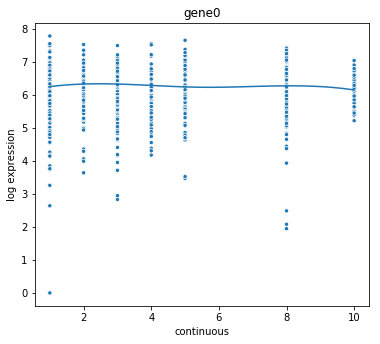

In [23]:
det_refbatch.plot_genes(
    genes=data.var_names[0],
    log=True
)

## Run test with constrained model

Instead of using references batches and to avoid the arbitrariness in their choice, we can constrain the individual effects within each time point to sum to zero so that we account for the added variance in the model but restrict the time trajectory to model the mean of the individuals at each time point.

Diffxpy allows this type of model through the constraints interface. Here, we can supply the constraint as a dictionary that contains the nested confounder (individual) that should be stratified by the covariate that it is nested in (time): `constraints_loc={"individual": "time"}`. Note that this constraint is only enforced on the location model (`constraints_loc`) because the scale model is simply an intercept here.

For more information on constraints, see also the constraints tutorial: TODO-link.

In [24]:
det_constr = de.test.continuous_1d(
    data=data.X, 
    sample_description=data.obs,
    gene_names=data.var_names,
    formula_loc="~ 1 + time + individual",
    formula_scale="~ 1",
    factor_loc_totest="time",
    continuous="time",
    constraints_loc={"individual": "time"},
    df=4,
    quick_scale=True
)

W0903 18:57:03.482414 4680238528 data.py:398] Built constraints: individual[0_1]+individual[1_1]+individual[2_1]=0, individual[0_2]+individual[1_2]+individual[2_2]=0, individual[0_3]+individual[1_3]+individual[2_3]=0, individual[0_4]+individual[1_4]+individual[2_4]=0, individual[0_5]+individual[1_5]+individual[2_5]=0, individual[0_8]+individual[1_8]+individual[2_8]=0, individual[0_10]+individual[1_10]+individual[2_10]=0
I0903 18:57:05.313542 4680238528 estimator.py:113] training strategy:
[{'convergence_criteria': 'all_converged',
  'optim_algo': 'irls_gd_tr',
  'use_batching': False}]
I0903 18:57:05.314256 4680238528 estimator.py:116] Beginning with training sequence #1
I0903 18:57:07.753000 4680238528 estimator.py:118] Training sequence #1 complete


Note that diffxpy showed the exact constraints with coefficient names that it used. We do this so that there are no misunderstandings about this contraint interface. If you do not want to see this, you have to switch the logging stream to `error`.

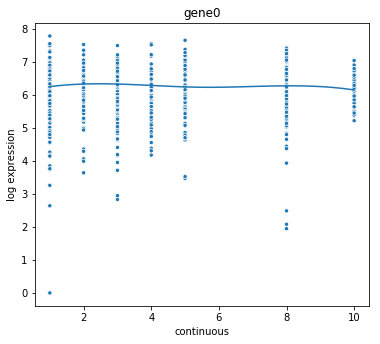

In [25]:
det_refbatch.plot_genes(
    genes=data.var_names[0],
    log=True
)

# Advanced: Condition effects

Above, we showed how one can use differential expression analysis to test whether a gene's expression is constant with respect to a continuous covariate such as time.

We showed how this can be done in the language of linear models. Naturally, one can also use this language to ask more complex questions. In this section, we showcase a few advanced use cases of differential expression analysis with contiuous covariates

The data that we use here represents multiple parallel time series experiments, e.g. across conditions. We simulate 7 time points in two conditions (treated and untreated) with 3 replicates each.

In [26]:
from batchglm.api.models.glm_nb import Simulator

sim = Simulator(num_observations=700, num_features=100)
sim.generate_sample_description(num_batches=7, num_conditions=2)
sim.generate_params(
    rand_fn_loc=lambda shape: np.random.uniform(-1, 1, shape),
    rand_fn_scale=lambda shape: np.random.uniform(0.1, 2, shape)
)
sim.generate_data()

data_cond = anndata.AnnData(
    X=sim.x,
    var=pd.DataFrame(index=["gene" + str(i) for i in range(sim.x.shape[1])]),
    obs=sim.sample_description
)
time_list = np.array([1, 2, 3, 4, 5, 8, 10])
data_cond.obs["time"] = [time_list[int(x)] for x in data_cond.obs["batch"].values]
data_cond.obs["condition"] = [{"0": "treated", "1": "untreated"}[x] for x in data_cond.obs["condition"].values]
data_cond.obs["individual"] = [
    str(np.random.randint(0, 3)) + "_" + str(data_cond.obs["time"].values[i]) + "_" + data_cond.obs["condition"].values[i]
    for i in range(len(data_cond.obs["time"].values))
]

Transforming to str index.


## Testing for trajectory shifts across conditions 

Advanced tests  with continuous covariates become necessary if one wants to compare different trajectories. These trajectories can occur for example if a time series was sampled in separate conditions or cell types or if the response of cell type to stimulation experiments with varying concentration for multiple chemicals were performed. 

The most basic model for differences in trajectories is a single trajectory across the continuous covariate that has a different intercept in each condition. This means, that only one parameter per condition is tested and that all trajectories have the same shape and only differ in a scaling factor.

Note that the continous effect is still `time`, but the tested effect is now the categorical `condition covariate`. We ignore batch effects introduced on the level of `individual`, they can be accounted for as described above. So in this example:
- `factor_loc_totest=["condition"]` means that we test any variation across conditions, this only corresponds to a scaling factor for each condition
- `factor_loc_totest=["time"]` means that we test any variation across time, ignoring scaling factor differences between conditions
- `factor_loc_totest=["time", "condition"]` means that we test any variation across time and condition, so here we detect all genes that are non-constant in any condition.

In [27]:
det_shift = de.test.continuous_1d(
    data=data_cond,
    formula_loc="~ 1 + time + condition",
    formula_scale="~ 1",
    factor_loc_totest="condition",
    continuous="time",
    df=4,
    quick_scale=True
)

I0903 18:57:10.217456 4680238528 estimator.py:113] training strategy:
[{'convergence_criteria': 'all_converged',
  'optim_algo': 'irls_gd_tr',
  'use_batching': False}]
I0903 18:57:10.221451 4680238528 estimator.py:116] Beginning with training sequence #1
I0903 18:57:11.438996 4680238528 estimator.py:118] Training sequence #1 complete


How does this look? Let's plot a single genes trajectory across time and conditions:

In [28]:
det_shift._model_estim.model.design_loc_names  # Look at the coefficient names.

['Intercept', 'condition[T.untreated]', 'time0', 'time1', 'time2', 'time3']

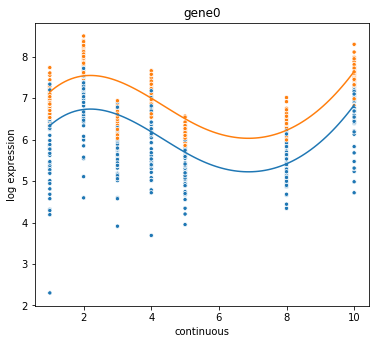

In [29]:
det_shift.plot_genes(
    genes=np.argmin(det_shift.log10_pval_clean()),
    hue=data_cond.obs["condition"].values,
    scalings=["condition[T.untreated]"],  # The coefficient names corresponding to condition. 
    log=True
)

You can clearly see that the models are simply scaled and that this can capture some variation between the conditions, however a model that could account for trajectory shape differences between the conditions seems more approriate here.

## Testing for trajectories shape differences across conditions

The test for trajectory shape differences has a similar motivation as the trajectory shift test does but correponds to a more complex alternative model: Instead of allowing only for relative differences in the behaviour across the continuous covariate, this test allows for arbitrary differences. Here the complexity of the difference in shape is again parameterised by a spline basis. Therefore the degrees of freedom of the model that are tested are the parameters used for this "differential" spline basis.

One may be interested to perform this test if one has densely sampled trajectories from two conditions and wants to know, whether these trajectories differ.

We can perform a test that ignores differences that can be explained by a scaling factor by excluding the `condition` effect from the tested factors. If we include this factor, we test for any difference between the two trajectories. So in this example:
- `factor_loc_totest=["time:condition", "condition"]` means that we test any variation across condition, including intercept and relative differences
- `factor_loc_totest=["time:condition", "time"]` means that we test any variation across time, including differential temporal behaviour across conditions.
- `factor_loc_totest=["time:condition", "time", "condition"]` means that we test any variation across time and condition, again targetting all genes that are non-constant across time.

In [30]:
det_condition_trajectories = de.test.continuous_1d(
    data=data_cond,
    formula_loc="~ 1 + time + condition + time:condition",
    formula_scale="~ 1",
    factor_loc_totest=["time:condition", "condition"],
    continuous="time",
    df=4,
    quick_scale=True
)

I0903 18:57:13.919014 4680238528 estimator.py:113] training strategy:
[{'convergence_criteria': 'all_converged',
  'optim_algo': 'irls_gd_tr',
  'use_batching': False}]
I0903 18:57:13.919914 4680238528 estimator.py:116] Beginning with training sequence #1
I0903 18:57:15.002437 4680238528 estimator.py:118] Training sequence #1 complete


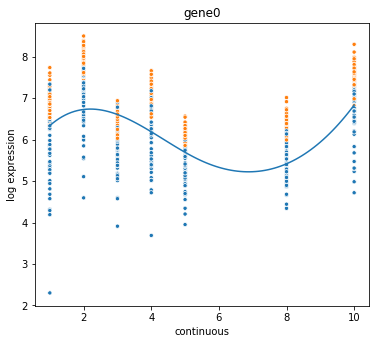

In [31]:
det_shift.plot_genes(
    genes=np.argmin(det_condition_trajectories.log10_pval_clean()),
    hue=data_cond.obs["condition"].values,
    log=True
)

We do not have a dedicated plotting function that resolves these condition-wise trajectories yet, but this is coming soon!

# Advanced: Choice of spline basis

Diffxpy uses [patsy](https://patsy.readthedocs.io/en/latest/spline-regression.html) to assemble spline basis spaces. **Note that we do not fit with patsy** as with still use our own fitting machinery which involves different noise models, sparse data, size factors etc.. We simply use the great interface of patsy to build the spline basis space, this is a transform on the design matrix that does not involve GLM parameter estimation.

We support different spline basis spaces, these are all implemented in patsy. They can be accessed through the `spline_basis: str` arguemnt to `de.test.continuous_1d()`. We currently support B-splines (`"bs"`), natural cubic spliens (`"cr"`) and natural cyclic splines (`"cc"`). B-splines are the default. Many continuous trends can be captured by all of these spline basis: They differ in the shape of their wave functions but these can be differentially weighted during model fitting. As an example, we show the three wave function sets for an example input:

I0903 18:57:17.198347 4680238528 estimator.py:113] training strategy:
[{'convergence_criteria': 'all_converged',
  'optim_algo': 'irls_gd_tr',
  'use_batching': False}]
I0903 18:57:17.199033 4680238528 estimator.py:116] Beginning with training sequence #1
I0903 18:57:19.110981 4680238528 estimator.py:118] Training sequence #1 complete


B-splines:


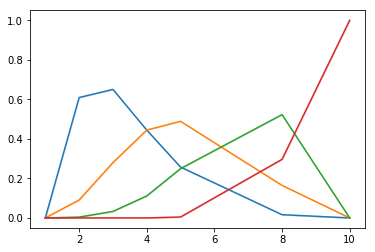

In [32]:
det = de.test.continuous_1d(
    data=data.X,
    sample_description=data.obs,
    gene_names=data.var_names,
    formula_loc="~ 1 + time",
    formula_scale="~ 1",
    factor_loc_totest="time",
    continuous="time",
    df=4,
    spline_basis="bs",  # Spline basis choice.
    quick_scale=True
)
print("B-splines:")
for x in ['time0', 'time1', 'time2', 'time3']:
    sns.lineplot(x=data.obs["time"].values, y=data.obs[x].values)

I0903 18:57:21.373146 4680238528 estimator.py:113] training strategy:
[{'convergence_criteria': 'all_converged',
  'optim_algo': 'irls_gd_tr',
  'use_batching': False}]
I0903 18:57:21.373912 4680238528 estimator.py:116] Beginning with training sequence #1
I0903 18:57:22.110261 4680238528 estimator.py:118] Training sequence #1 complete


Natural cubic splines:


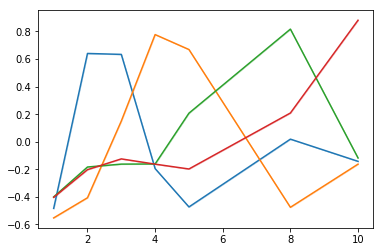

In [33]:
det = de.test.continuous_1d(
    data=data.X,
    sample_description=data.obs,
    gene_names=data.var_names,
    formula_loc="~ 1 + time",
    formula_scale="~ 1",
    factor_loc_totest="time",
    continuous="time",
    df=4,
    spline_basis="cr",  # Spline basis choice.
    quick_scale=True
)
print("Natural cubic splines:")
for x in ['time0', 'time1', 'time2', 'time3']:
    sns.lineplot(x=data.obs["time"].values, y=data.obs[x].values)

I0903 18:57:24.632614 4680238528 estimator.py:113] training strategy:
[{'convergence_criteria': 'all_converged',
  'optim_algo': 'irls_gd_tr',
  'use_batching': False}]
I0903 18:57:24.633749 4680238528 estimator.py:116] Beginning with training sequence #1
I0903 18:57:25.425569 4680238528 estimator.py:118] Training sequence #1 complete


Natural cyclic splines:


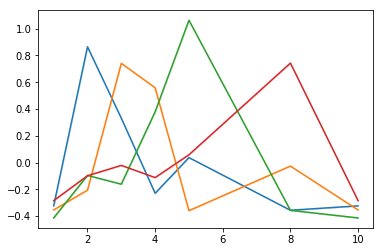

In [34]:
det = de.test.continuous_1d(
    data=data.X,
    sample_description=data.obs,
    gene_names=data.var_names,
    formula_loc="~ 1 + time",
    formula_scale="~ 1",
    factor_loc_totest="time",
    continuous="time",
    df=4,
    spline_basis="cc",  # Spline basis choice.
    quick_scale=True
)
print("Natural cyclic splines:")
for x in ['time0', 'time1', 'time2', 'time3']:
    sns.lineplot(x=data.obs["time"].values, y=data.obs[x].values)

Lastly, we would like to note that all of these spline functions are centred, they do not contain an intercept, as we model the intercept separately in diffxpy to allow testing of only the continuous effects.